<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises

The following is a template for 02. PyTorch Classification exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [ ]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors. 
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [ ]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000,
                 random_state=RANDOM_SEED)
X[:5], y[:5]

In [ ]:
# Turn data into a DataFrame
import pandas as pd

df = pd.DataFrame({'X0': X[:, 0], 'X1': X[:, 1], 'y': y})
df.head()

In [ ]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Turn data into tensors of dtype float
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float) 
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [ ]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    
    def __init__(self, in_features, out_features, hidden_features=100):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=out_features),
        )

    def forward(self, x):
        return self.linear_stack(x)

# Instantiate the model
model = MoonModelV0(in_features=2, out_features=1).to(device)
model

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [ ]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optim = torch.optim.SGD(params=model.parameters(), lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [ ]:
# What's coming out of our model?
# logits (raw outputs of model)
logits = model(X_train)
print("Logits:", logits[:5])
# Prediction probabilities
probs = torch.sigmoid(logits)
print("Pred probs:", probs[:5])
# Prediction labels
labels = torch.round(probs)
print("Pred labels:", labels[:5])

In [ ]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

In [ ]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 200

# Send data to the device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
    model.train()

  # 1. Forward pass (logits output)
    logits = model(X_train).squeeze()
  # Turn logits into prediction probabilities
    probs = torch.sigmoid(logits)
  # Turn prediction probabilities into prediction labels
    labels = torch.round(probs)

  # 2. Calculaute the loss
    loss = loss_fn(logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
    acc = acc_fn(labels, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
    optim.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
    loss.backward()
  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
    optim.step()

  ### Testing
    model.eval() 
    with torch.inference_mode():
    # 1. Forward pass (to get the logits)
        test_logits = model(X_test).squeeze()
    # Turn the test logits into prediction labels
        test_labels = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_labels, y_test.int())

  # Print out what's happening every 100 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch} Loss: {loss:.5f} Acc: {acc:.2f}% Test loss: {test_loss:.5f} Test Acc: {test_acc:.2f}%")

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [9]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [ ]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model, X_train, y_train)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [ ]:
# Create a straight line tensor
line = torch.arange(1, 5, 0.5)
line

In [ ]:
# Test torch.tanh() on the tensor and plot it
tanh = torch.tanh(line)
plt.plot(tanh)

In [ ]:
# Replicate torch.tanh() and plot it
def tanh_fn(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
tanh = tanh_fn(line)
plt.plot(tanh)

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

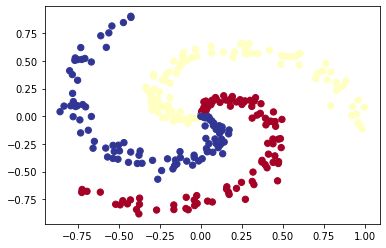

In [1]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [2]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print(len(X_train), len(X_test))
print(X[:5], y[:5])

240 60
tensor([[0.0000, 0.0000],
        [0.0001, 0.0101],
        [0.0042, 0.0198],
        [0.0125, 0.0276],
        [0.0046, 0.0401]]) tensor([0, 0, 0, 0, 0])


In [3]:
# Let's calculuate the accuracy for when we fit our model
from torchmetrics import Accuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn

C:\Users\InE_STD\anaconda3\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


MulticlassAccuracy()

In [4]:
from torch import nn

# Create model by subclassing nn.Module
class SpiralModel(nn.Module):
    def __init__(self, in_features=D, out_features=K, hidden_features=100):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_features),
            nn.Tanh(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.Tanh(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.Tanh(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.Tanh(),
            nn.Linear(in_features=hidden_features, out_features=out_features),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.stack(x)

# Instantiate model and send it to device
spiralmodel = SpiralModel().to(device)
spiralmodel

SpiralModel(
  (stack): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=3, bias=True)
    (9): Softmax(dim=1)
  )
)

In [5]:
# Setup data to be device agnostic
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Print out first 10 untrained model outputs (forward pass)
probs = spiralmodel(X_train)
print("Pred probs:", probs[:10])
labels = torch.argmax(probs, dim=1)
print("Pred labels:", labels[:10])

Pred probs: tensor([[0.3319, 0.3420, 0.3262],
        [0.3297, 0.3399, 0.3304],
        [0.3311, 0.3452, 0.3237],
        [0.3232, 0.3442, 0.3325],
        [0.3257, 0.3484, 0.3259],
        [0.3286, 0.3453, 0.3262],
        [0.3295, 0.3456, 0.3249],
        [0.3368, 0.3436, 0.3196],
        [0.3274, 0.3409, 0.3316],
        [0.3231, 0.3443, 0.3326]], grad_fn=<SliceBackward0>)
Pred labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [6]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=spiralmodel.parameters(), lr=0.001)

In [7]:
# Build a training loop for the model
epochs = 200
# Loop over data
for epoch in range(epochs):
    spiralmodel.train()
  ## Training
  # 1. Forward pass
    preds = spiralmodel(X_train)
    labels = preds.argmax(dim=1)    
  # 2. Calculate the loss
    loss = loss_fn(preds, y_train)
    acc = acc_fn(labels, y_train)
  # 3. Optimizer zero grad
    optim.zero_grad()
  # 4. Loss backward
    loss.backward()
  # 5. Optimizer step
    optim.step()
  ## Testing
    spiralmodel.eval()
    with torch.inference_mode():
    # 1. Forward pass
        test_preds = spiralmodel(X_test)
        test_labels = test_preds.argmax(dim=1)
    # 2. Caculate loss and acc
        test_loss = loss_fn(test_preds, y_test)
        test_acc = acc_fn(test_labels, y_test)
  # Print out what's happening every 100 epochs
    if epoch%10==0:
        print(f"Epoch: {epoch} Loss: {loss:.5f} Acc: {acc:.2f} Test Loss: {test_loss:.5f} Test Acc: {test_acc:.2f}")

Epoch: 0 Loss: 1.09883 Acc: 0.35 Test Loss: 1.09322 Test Acc: 0.42
Epoch: 10 Loss: 0.98858 Acc: 0.57 Test Loss: 0.98900 Test Acc: 0.50
Epoch: 20 Loss: 0.93017 Acc: 0.54 Test Loss: 0.93953 Test Acc: 0.52
Epoch: 30 Loss: 0.91507 Acc: 0.65 Test Loss: 0.93602 Test Acc: 0.67
Epoch: 40 Loss: 0.87838 Acc: 0.69 Test Loss: 0.88491 Test Acc: 0.72
Epoch: 50 Loss: 0.86580 Acc: 0.69 Test Loss: 0.86849 Test Acc: 0.68
Epoch: 60 Loss: 0.85362 Acc: 0.71 Test Loss: 0.86900 Test Acc: 0.72
Epoch: 70 Loss: 0.84139 Acc: 0.73 Test Loss: 0.85755 Test Acc: 0.73
Epoch: 80 Loss: 0.82882 Acc: 0.74 Test Loss: 0.84553 Test Acc: 0.73
Epoch: 90 Loss: 0.81530 Acc: 0.74 Test Loss: 0.83104 Test Acc: 0.73
Epoch: 100 Loss: 0.79661 Acc: 0.76 Test Loss: 0.81189 Test Acc: 0.73
Epoch: 110 Loss: 0.75308 Acc: 0.81 Test Loss: 0.73790 Test Acc: 0.82
Epoch: 120 Loss: 0.68712 Acc: 0.88 Test Loss: 0.68434 Test Acc: 0.88
Epoch: 130 Loss: 0.65414 Acc: 0.91 Test Loss: 0.65192 Test Acc: 0.90
Epoch: 140 Loss: 0.64082 Acc: 0.91 Test Loss:

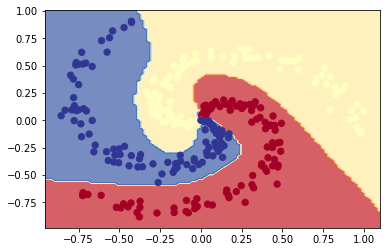

In [10]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(spiralmodel, X, y)